In [1]:
from pathlib import Path
import sys
sys.path.append(str(Path().resolve().parent))
import os
os.environ['OMP_NUM_THREADS'] = "1"
%env OMP_NUM_THREADS=1

env: OMP_NUM_THREADS=1


X_train.shape=(1437, 64)


C:\Users\kazum\AppData\Local\Temp\ipykernel_11048\2930909106.py:63: DeprecationWarning: This method is deprecated. Use `generate_bound_params` instead.
  X_train_state[i] = (quantum_state(n_qubits=n_qubits,circuit=pqc.bind_input_and_parameters(x,[])))


 1436/1437
calculating p_ij
 1436/1437
calculating fidelity
 1436/1437elapsed time:9.365772399999969


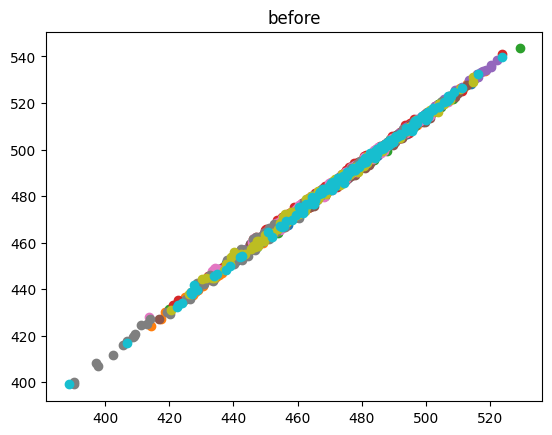

epoch:0 loss:0.0
 2873/2874grads=array([-9.65042934e-04,  1.16928467e-03,  2.89364910e-03, ...,
       -2.48352450e-05,  2.64942646e-03, -2.22932606e-03])
 2873/2874grads=array([-0.00116583,  0.00140516,  0.00236653, ..., -0.00015404,
        0.00137547, -0.00095792])
 2873/2874grads=array([-0.00093146,  0.00122601,  0.0017335 , ..., -0.00011771,
        0.00087571, -0.0004725 ])
 2873/2874grads=array([-7.81610110e-04,  1.07656661e-03,  1.35555012e-03, ...,
       -7.79178944e-05,  6.19461371e-04, -2.66855427e-04])
 2873/2874grads=array([-6.49660326e-04,  9.80432846e-04,  1.11346621e-03, ...,
       -1.07072129e-05,  4.61317207e-04, -1.24770194e-04])
 2873/2874grads=array([-5.72295988e-04,  9.18578991e-04,  9.29442079e-04, ...,
       -5.93658456e-06,  3.92064159e-04, -1.87860838e-05])
 2873/2874grads=array([-4.92488939e-04,  8.25426172e-04,  8.04011302e-04, ...,
        3.85995680e-05,  3.23849392e-04,  3.19566595e-05])
 2873/2874grads=array([-4.99686514e-04,  7.37260919e-04,  7.07453

In [ ]:
from scikit_quri.qnn.kernel_tsne import quantum_kernel_tsne, pqc_f_helper
import numpy as np
from quri_parts.circuit import H, CZ
from sklearn.datasets import load_iris, load_digits
from sklearn.preprocessing import MinMaxScaler
from scikit_quri.circuit import LearningCircuit
from quri_parts.core.state import quantum_state
from numpy.typing import NDArray
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold

def create_quantum_circuit():
    qc = LearningCircuit(n_qubits)

    def preprocess_x(x: NDArray[np.float64], index: int) -> float:
        xa = x[index % len(x)]
        return min(1, max(-1, xa))

    for i in range(n_qubits):
        qc.add_gate(H(i))
    for d in range(depth):
        for i in range(n_qubits):
            qc.add_input_RY_gate(i, lambda x, i=i: preprocess_x(x, i))
        for i in range(n_qubits):
            qc.add_input_RX_gate(i, lambda x, i=i: preprocess_x(x, i))
        if d < depth - 1:
            for i in range(n_qubits):
                qc.add_gate(CZ(i, (i + 1) % n_qubits))
    return qc
# X, Y = load_iris(return_X_y=True)
X,Y = load_digits(return_X_y=True)
X = X / 16.
n_features = 12

skf = StratifiedKFold()
for tr_index, te_index in skf.split(X,Y):
    break


X_train = X[tr_index]
X_test = X[te_index]
y_train = Y[tr_index]
y_test = Y[te_index]
print(f"{X_train.shape=}")

pca = PCA(n_components=n_features)
pca.fit(X_train)
X_train = pca.transform(X_train)
X_test = pca.transform(X_test)
# X_train = X_train / 16.
# X_train = X_train[:200]
# y_train = y_train[:200] #500 => fidelity 81.6[s]
scaler = MinMaxScaler((0, np.pi / 2))
n_qubits = 12
depth = 1

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
qk_tsne = quantum_kernel_tsne(max_iter=5000)
X_train_state = np.zeros(len(X_train),dtype=object)
pqc = create_quantum_circuit()
for i,x in enumerate(X_train):
    X_train_state[i] = (quantum_state(n_qubits=n_qubits,circuit=pqc.bind_input_and_parameters(x,[])))
p_probs = (qk_tsne.tsne.calc_probabilities_p_state(X_train_state))
# print(f"{p_probs=}")
qk_tsne.init(create_quantum_circuit, [])
qk_tsne.train(X_train, y_train, method="adam")

pred_y= (qk_tsne.transform(X_test))
qk_tsne.plot(pred_y, y_test, "test")


In [ ]:
from scipy.spatial import distance
# M = np.random.randint(0, 10, (5, 2))
M = np.array([[np.random.rand()] for _ in range(5) ])
cdist = distance.cdist(M,M)
print(cdist)

[[0.         0.33536119 0.07501275 0.07827386 0.77649828]
 [0.33536119 0.         0.26034844 0.25708733 0.44113709]
 [0.07501275 0.26034844 0.         0.00326111 0.70148553]
 [0.07827386 0.25708733 0.00326111 0.         0.69822442]
 [0.77649828 0.44113709 0.70148553 0.69822442 0.        ]]


In [ ]:
print(f"{M=}")
x1_norm = np.sum(M**2,axis=1)[:,np.newaxis]
print(f"{x1_norm=}")
x1_pad = np.ones_like(x1_norm)
print(f"{x1_norm.shape=}")
print(f"{x1_pad.shape=}")
print(f"{(-2*M).shape=}")
# phi = np.concatenate((-2*M,np.sum(M**2,axis=1),np.ones((len(M),1))))
psi = np.concatenate((-2*M,x1_norm,x1_pad),axis=1)
print(psi)

M=array([[0.21625382],
       [0.55161501],
       [0.29126657],
       [0.29452768],
       [0.9927521 ]])
x1_norm=array([[0.04676572],
       [0.30427912],
       [0.08483622],
       [0.08674656],
       [0.98555673]])
x1_norm.shape=(5, 1)
x1_pad.shape=(5, 1)
(-2*M).shape=(5, 1)
[[-0.43250764  0.04676572  1.        ]
 [-1.10323003  0.30427912  1.        ]
 [-0.58253314  0.08483622  1.        ]
 [-0.58905537  0.08674656  1.        ]
 [-1.9855042   0.98555673  1.        ]]


In [ ]:
x2_norm = np.sum(M**2,axis=1)[:,np.newaxis]
x2_pad = np.ones_like(x2_norm)
phi = np.concatenate((M,x2_pad,x2_norm),axis=1)
print(phi)

[[0.21625382 1.         0.04676572]
 [0.55161501 1.         0.30427912]
 [0.29126657 1.         0.08483622]
 [0.29452768 1.         0.08674656]
 [0.9927521  1.         0.98555673]]


In [ ]:
D_2 = psi @ phi.T
D_2 = np.sqrt(D_2)
print(D_2)

[[0.         0.33536119 0.07501275 0.07827386 0.77649828]
 [0.33536119 0.         0.26034844 0.25708733 0.44113709]
 [0.07501275 0.26034844 0.         0.00326111 0.70148553]
 [0.07827386 0.25708733 0.00326111 0.         0.69822442]
 [0.77649828 0.44113709 0.70148553 0.69822442 0.        ]]


In [ ]:
np.isclose(D_2,cdist)

array([[ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True]])

In [ ]:
# import torch
# from inspect import getsource,getfile
# M = np.array([[np.random.rand()] for _ in range(6) ])
# M_t = torch.tensor(M,dtype=torch.float64,requires_grad=True)
# cdist = torch.cdist(M_t,M_t)
# print(f"{getfile(cdist.grad_fn)=}")
# print(f"{dir(cdist.grad_fn)=}")
# s = torch.sum(cdist)
# s.backward()
# print(f"{M_t.grad=}")

In [ ]:
# grad